# Introducción

En el idioma japonés, existen 3 abecedarios diferentes: hiragana, katakana y kanji. 

El katakana y hiragana son considerados silabarios ya que la fonética de cada uno de los símbolos que los componen consta del sonido de una consonante y luego una vocal. Así, por ejemplo, el símbolo か se pronunca "ka".

En particular, el katakana suele ser utilizado para palabras extranjeras. Observando la palabra パソコン ("pasokon"), la misma está escrita en katakana, siendo un fonetismo de la palabra anglosajona "Personal Computer" acortada "Perso(nal) Comp". Por otro lado, los kanji son ni más ni menos que símbolos heredados del chino antigüo dotados de un significado en sí. Entonces, 卵 es el kanji para "huevo" para dar un ejemplo.

Finalmente, se encuentra el hiragana. Este nos permite saber la pronunciación de una palabra y es posible realizar un mapeo 1 a 1 con letras que generen los mismos sonidos que el español (al igual que como sucede con el katakana). En Japón, son utilizados para señales que todo el mundo debe poder identificar o para índicar la pronunciación de un kanji.

Como dato curioso, en el juego Pokémon, al iniciar una nueva partida, se puede seleccionar si se quiere que los dialogos se encuentren con una combinación de kanji y hiragana o que los mismos se encuentren únicamente con los hiragana correspondientes. Esto es porque los más pequeños no pueden leer kanji.

Bajo esta premisa, el siguiente trabajo busca identificar los hiragana que pueden aparecer en carteles y señales alrededor de Japón. No se busca una traducción ni un mapeo a nuestra fonética de los mismos, solo identificarlos y obtener el carácter unicode correspondiente. De todas maneras, el trabajo abre las puertas para tomar el resultado y realizar los experimentos mencionados.

# Pipeline

El proceso de identificar los hiragana en un letrero se encuentra dividido en dos partes fundamentales: la separación de los hiragana que se encuentran en la imágen y la identificación en sí del kanji (predecir que kanji es cada uno).

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

2024-12-03 22:57:39.612013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:57:39.613035: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 22:57:39.615972: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 22:57:39.623823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733277459.636412  920453 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733277459.63

## Modelo

Para el segundo apartado (la identificación del kanji), se entrenó un modelo de Red Convolucional a partir del dataset Kuzushiji-49 que contiene ejemplos de los 46 hiragana estándar y 3 hiragana antigüos manuscritos. Consta, en total, de 270.912 imágenes de 28x28 pixeles separadas en train y test.

(incluir foto del conjunto de entrenamiento)

In [ ]:
batch_size = 128
num_classes = 49
epochs = 350

# input image dimensions
img_rows, img_cols = 28, 28

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('k49-train-imgs.npz')
x_test = load('k49-test-imgs.npz')
y_train = load('k49-train-labels.npz')
y_test = load('k49-test-labels.npz')

In [ ]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('{} train samples, {} test samples'.format(len(x_train), len(x_test)))

232365 train samples, 38547 test samples


In [ ]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 168s 92ms/step - accuracy: 0.0274 - loss: 3.8830 - val_accuracy: 0.0766 - val_loss: 3.8312
Epoch 2/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 169s 93ms/step - accuracy: 0.0645 - loss: 3.8052 - val_accuracy: 0.1164 - val_loss: 3.7331
Epoch 3/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 170s 94ms/step - accuracy: 0.1005 - loss: 3.6881 - val_accuracy: 0.1625 - val_loss: 3.5785
Epoch 4/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 170s 94ms/step - accuracy: 0.1434 - loss: 3.5165 - val_accuracy: 0.2137 - val_loss: 3.3836
Epoch 5/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 170s 94ms/step - accuracy: 0.1954 - loss: 3.3180 - val_accuracy: 0.2584 - val_loss: 3.1889
Epoch 6/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 172s 94ms/step - accuracy: 0.2382 - loss: 3.1313 - val_accuracy: 0.3002 - val_loss: 3.0201
Epoch 7/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 170s 94ms/step - accuracy: 0.2751 - loss: 2.9697 - val_accuracy: 0.3402 - val_loss: 2.8784
Epoch 8/350
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 171s 94ms/step - ac

El entrenamiento fue realizado por el término de 350 épocas obteniéndose una accuracy y precision del 78.15% para el conjunto de prueba.

(incluir foto del accuracy a lo largo de las épocas)

In [ ]:
# Metrics
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Train loss: 0.4342772960662842
Train accuracy: 0.8883481025695801
Test loss: 0.8442897200584412
Test accuracy: 0.7814615964889526


In [ ]:
# Realizar predicciones en todo el conjunto de prueba
predictions = model.predict(x_test)

# Obtener las clases predichas
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases verdaderas
true_classes = np.argmax(y_test, axis=1)

# Contar cuántas predicciones son correctas
correct_predictions = np.sum(predicted_classes == true_classes)

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

print(f"Total de imágenes en el conjunto de prueba: {len(y_test)}")
print(f"Predicciones correctas: {correct_predictions}")
print(f"Precisión en el conjunto de prueba: {accuracy:.2%}")


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
Total de imágenes en el conjunto de prueba: 38547
Predicciones correctas: 30123
Precisión en el conjunto de prueba: 78.15%


In [ ]:
model.save('kanji_model_350_epochs.hdf5')

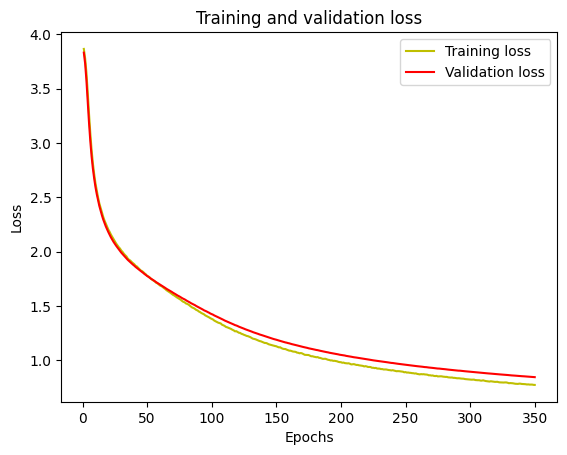

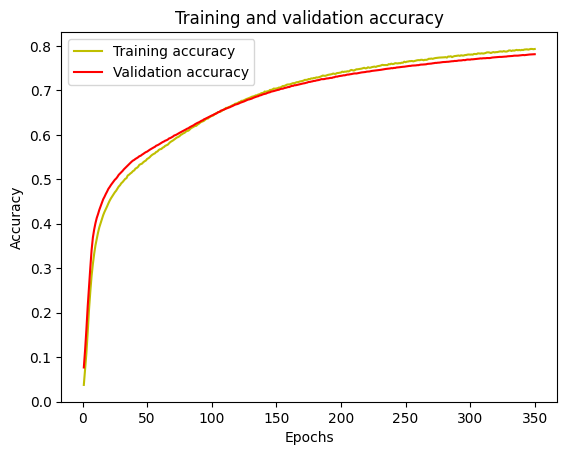

In [ ]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

La entrada del modelo es la matriz de 28x28 pixeles que representa la imágen, dicha matriz esta escalada a un intervalo [0, 1]. La salida de la red es un vector de 49 posiciones donde en cada posición se encuentra la probabilidad que la entrada pertenezca a esa clase.

Luego, es posible cargar el modelo ya entrenado como se muestra a continuación:

In [2]:
num_classes = 49

def load(f):
    return np.load(f)['arr_0']

# Based on train set
x_img = load('model/k49-train-imgs.npz')
y_class = keras.utils.to_categorical(load('model/k49-train-labels.npz'), num_classes)
y_class = np.argmax(y_class, axis=1)

# Checking the number of classes
y_class_unique = np.unique(y_class)

## Segmentación

Por otro lado, para la separación de los hiragana se aplicó la transformada de Hough para identificar bordes. Primero, a la imágen se le realiza una transformación por threshold, asignando a todos los valores por debajo de 127 de luminancia el blanco mientras que a los mayores el negro.

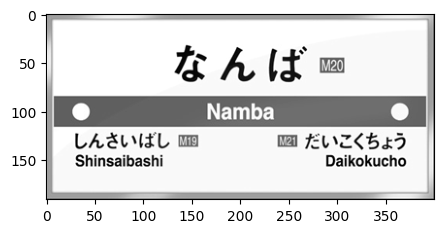

In [3]:
IMG_NAME = "hiragana_sign_1.png"

# B&W Convertion
img = cv2.imread("./images/"+IMG_NAME)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


fig = plt.figure()
fig.set_size_inches(5, 5)
plt.imshow(img, cmap='gray')
plt.show()

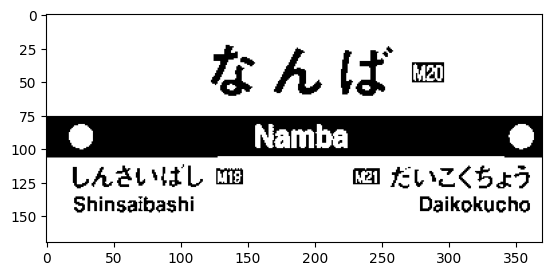

In [4]:
# Apply Threshold Transformation
_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
img = img[10:180, 10:380]
plt.imshow(img, cmap='gray')
plt.show()

Luego, se aplica un Gaussian Blur para eliminar ruido y suavizar pequeñas diferencias en los trazos.

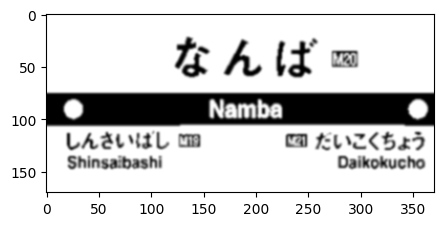

In [5]:
# Blurred
blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

fig = plt.figure()
fig.set_size_inches(5, 5)
plt.imshow(blurred_image, cmap='gray')
plt.show()

Al resultado se le aplica la función Canny para obtener los bordes presentes.

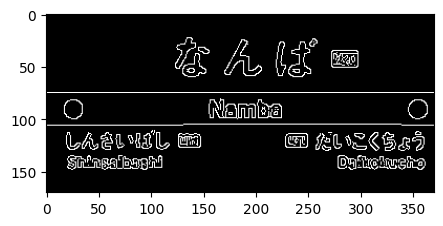

In [6]:
# Canny
canny_image = cv2.Canny(blurred_image, 225, 255)

fig = plt.figure()
fig.set_size_inches(5, 5)
plt.imshow(canny_image, cmap='gray')
plt.show()

Mediante la transformada de Hough se consiguen las ubicaciones de dichos trazados.

Posteriormente se realiza el armado del recuadro donde se encuentra cada símbolo. Para ello, a cada línea detectada se le define un rectángulo con las coordenadas más a la izquierda, más a la derecha, más arriba y más abajo. Esto provoca múltiples rectángulos con intersección no nula, muchos de ellos pegados entre sí.

In [7]:
def _find_sections(canny_image: np.ndarray) -> tuple[list[tuple[tuple[int, int], tuple[int, int]]], np.ndarray]:
    contours, hierarchy = cv2.findContours(canny_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    square_sections_limits = []
    for contour in contours:
        highest = contour.max(axis=0)[0]
        lowest = contour.min(axis=0)[0]
        
        if highest[0] <= lowest[0]:
            continue
        if highest[1] <= lowest[1]:
            continue

        square_sections_limits.append(((lowest[1], (highest[1]+1)), (lowest[0], (highest[0]+1))))
    return square_sections_limits, hierarchy

def obtain_sections(
        canny_image: np.ndarray
        ) -> tuple[tuple[tuple[int, int], tuple[int, int]], np.ndarray]:
    canny_image_copy = canny_image.copy()
    square_sections_limits, hierarchy = _find_sections(canny_image_copy)
    return square_sections_limits, hierarchy

sections_limits, _ = obtain_sections(canny_image)

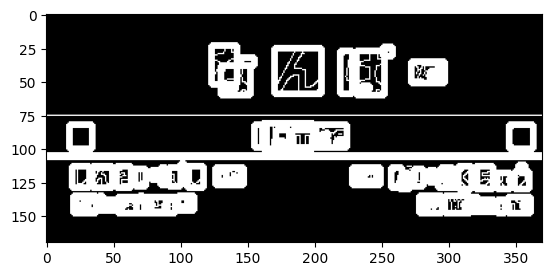

In [8]:
def _sections_to_square_contours(sections_limits: np.ndarray) -> tuple:
    square_contours = []
    for section_limit in sections_limits:
        square_contours.append(
                np.array(
                    [
                        np.array([[section_limit[1][0], section_limit[0][0]]]),
                        np.array([[section_limit[1][0], section_limit[0][1]-1]]),
                        np.array([[section_limit[1][1]-1, section_limit[0][1]-1]]),
                        np.array([[section_limit[1][1]-1, section_limit[0][0]]]),
                        np.array([[section_limit[1][0], section_limit[0][0]]]),
                    ]
                )
            )
    square_contours = tuple(square_contours)
    return square_contours

def draw_sections(
        canny_image: np.ndarray,
        sections_limits: list[tuple[tuple[int, int], tuple[int, int]]]
        ) -> np.ndarray:
    canny_image_copy = canny_image.copy()
    square_contours = _sections_to_square_contours(sections_limits)
    return cv2.drawContours(canny_image_copy, square_contours, -1, 255, 3)


plt.imshow(draw_sections(canny_image, sections_limits), cmap="grey")

Ahora bien, podemos decir que dos rectángulos con intersección no nula o que comience uno inmediatamente después de otro es indicativo de que se trata del mismo símbolo. Por lo tanto, calculamos los nuevos límites como el rectángulo que englobe a todos los otros que cumpla esta última condición.

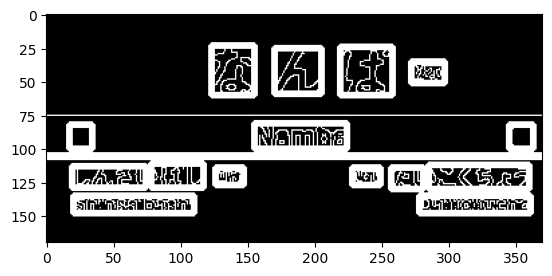

In [9]:
def _ranges_intersect(
        limit_a: tuple[int, int],
        limit_b: tuple[int, int],
        tol: float
        ) -> bool:
    min_a, max_a = limit_a
    min_b, max_b = limit_b
    if min_a < min_b:
        return max_a+tol >= min_b
    else:
        return max_b+tol >= min_a
    
def _augment_range(
        limit_a: tuple[int, int],
        limit_b: tuple[int, int]
        ) -> tuple[int, int]:
    min_a, max_a = limit_a
    min_b, max_b = limit_b
    lowest_min = min(min_a, min_b)
    highest_max = max(max_a, max_b)
    return (lowest_min, highest_max)
    
def _sections_intersect(
        section_a: tuple[tuple[int, int], tuple[int, int]],
        section_b: tuple[tuple[int, int], tuple[int, int]],
        tol: float
        ) -> bool:
    vertical_limits_a, horizontal_limits_a = section_a
    vertical_limits_b, horizontal_limits_b = section_b
    return _ranges_intersect(horizontal_limits_a, horizontal_limits_b, tol) and _ranges_intersect(vertical_limits_a, vertical_limits_b, tol)

def _augment_section(
        section_a: tuple[tuple[int, int], tuple[int, int]],
        section_b: tuple[tuple[int, int], tuple[int, int]]
        ) -> tuple[tuple[int, int], tuple[int, int]]:
    vertical_limits_a, horizontal_limits_a = section_a
    vertical_limits_b, horizontal_limits_b = section_b
    new_vertical_limits = _augment_range(vertical_limits_a, vertical_limits_b)
    new_horizontal_limits = _augment_range(horizontal_limits_a, horizontal_limits_b)
    return (new_vertical_limits, new_horizontal_limits)

def merge_all_sections(
        sections_limits: list[tuple[tuple[int, int], tuple[int, int]]],
        tol: float = 0
    ) -> list[tuple[tuple[int, int], tuple[int, int]]]:
    
    have_intersected = True

    while have_intersected:
        have_intersected = False

        group_labels_aux = list(range(len(sections_limits)))
        for i in range(len(sections_limits)):
            for j in range(len(sections_limits)):
                if i != j and _sections_intersect(sections_limits[i], sections_limits[j], tol):
                    have_intersected = True
                    group_label = min(group_labels_aux[i], group_labels_aux[j])
                    group_labels_aux[i] = group_label
                    group_labels_aux[j] = group_label

        group_labels = set()
        for group_label in group_labels_aux:
            group_labels.add(group_label)

        new_sections_limits = []
        for group_label in group_labels:
            new_section_limits = None
            for i in range(len(group_labels_aux)):
                if group_labels_aux[i] == group_label:
                    if new_section_limits is None:
                        new_section_limits = sections_limits[i]
                    else:
                        new_section_limits = _augment_section(new_section_limits, sections_limits[i])
            new_sections_limits.append(new_section_limits)

        sections_limits = new_sections_limits
                    
    return new_sections_limits

new_sections_limits = merge_all_sections(sections_limits, 2)
plt.imshow(draw_sections(canny_image, new_sections_limits), cmap="grey")

Para terminar con el seccionado, se recorta la imágen producto del filtro gaussiano a las porciones delimitadas por los rectángulos. Estos recortes constituyen los ejemplos a los que se debe identificar que hiragana le corresponde.

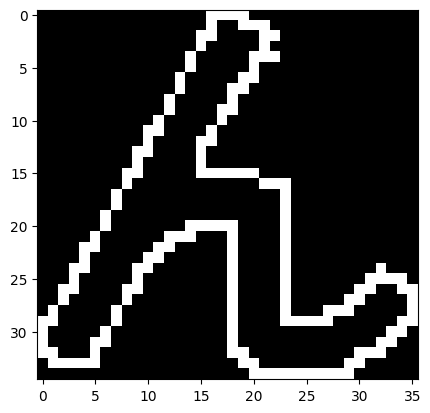

In [10]:
SECTION_VERTICAL = 0
SECTION_HORIZONTAL = 1
SECTION_LOWEST = 0
SECTION_HIGHEST = 1

def get_section(
        image: np.ndarray, 
        section_limits: tuple[tuple[int, int], tuple[int, int]]
        ) -> np.ndarray:
    return image[
        section_limits[SECTION_VERTICAL][SECTION_LOWEST]:section_limits[SECTION_VERTICAL][SECTION_HIGHEST], 
        section_limits[SECTION_HORIZONTAL][SECTION_LOWEST]:section_limits[SECTION_HORIZONTAL][SECTION_HIGHEST]
    ]

def sectionize_image(
        canny_image: np.ndarray, 
        sections_limits: list[tuple[tuple[int, int], tuple[int, int]]]
        ) -> list[np.ndarray]:
    sectionized_image = []
    for section_limits in sections_limits:
        sectionized_image.append(get_section(canny_image, section_limits))
    return sectionized_image

sections = sectionize_image(canny_image, new_sections_limits)
plt.imshow(sections[12], cmap="grey")

## Pre-Procesamiento de la Entrada

Las nuevas imágenes, resultado de la segmentación, contienen al hiragana a identificar. A cada hiragana se le aplica Canny y un cerrado morfológico de bordes para luego rellenar los trazos.

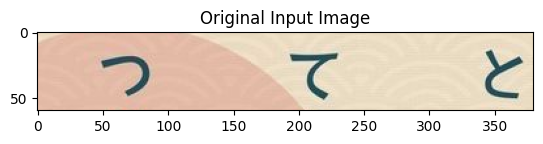

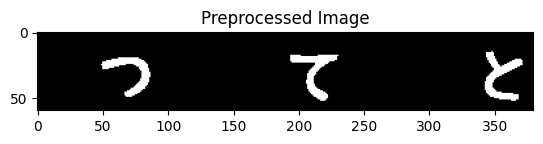

In [11]:
fill_borders = True

def input_preprocessing(img_name):

    # Load image
    img = cv2.imread("./images/"+img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[390:450, 300:680]

    plt.imshow(img, cmap="gray")
    plt.title("Original Input Image")
    plt.show()

    # B&W Convertion
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Blurred
    blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

    # Canny
    edges = cv2.Canny(blurred_image, 225, 255)

    if fill_borders:
        # Kernel for morphological operations
        kernel = np.ones((2, 1), np.uint8)
        
        # Morphological closing of gaps
        closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        
        # Find contours
        contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Fill
        mask = np.zeros_like(img)
        contours = cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
        
        processed_image = contours

    else:
        processed_image = edges

    plt.imshow(processed_image, cmap="gray")
    plt.title("Preprocessed Image")
    plt.show()

    # Sections
    sections_limits, _ = obtain_sections(processed_image)
    new_sections_limits = merge_all_sections(sections_limits, 2)
    sections = sectionize_image(processed_image, new_sections_limits)

    return processed_image, new_sections_limits, sections

img_name = "hiragana.png"
borders_image, section_limits, sections = input_preprocessing(img_name)

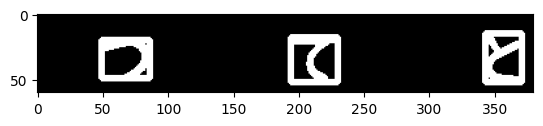

In [12]:
plt.imshow(draw_sections(borders_image, section_limits), cmap="grey")

Luego, se realiza una reducción de las dimensiones de la imágenes para que estas pasen a ser de 28x28 y se escala el valor de cada pixel al intervalo [0, 1].

## Pos-Procesamento de la Salida

Ahora se está en condiciones de predecir cada hiragana. Se obtiene un vector de 49 posiciones. Tomamos la posición con valor más grande de este vector que representa la clase ganadora por hiragana.

(imagen)

In [13]:
model = keras.saving.load_model("model/kanji_model_with_dynamic_augmentation.hdf5")

2024-12-03 22:57:42.680766: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


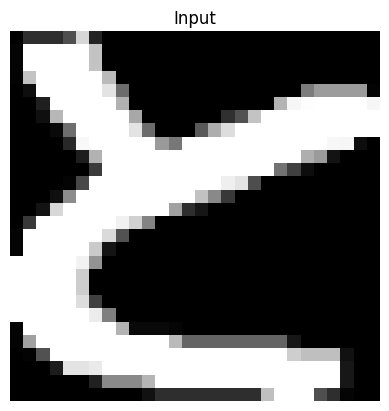

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [14]:
def predict_hiragana(target, show_plot=False):
    section = cv2.resize(target, (28, 28))
    
    if show_plot:
        plt.imshow(section, cmap="grey")
        plt.title("Input")
        plt.axis("off")
        plt.show()

    section = section.astype('float32')
    section /= 255

    predictions = model.predict(np.array([section]))
    prediction = predictions.argmax()

    return prediction

if fill_borders:
    target = sections[2]
else:
    target = sections[1]
prediction = predict_hiragana(target, show_plot=True)

Esta clase se la mapea al carácter unicode del hiragana que representa.

(imagen)

In [15]:
class2unicode = {
    0: "\u3042",
    1: "\u3044",
    2: "\u3046",
    3: "\u3048",
    4: "\u304A",
    5: "\u304B",
    6: "\u304D",
    7: "\u304F",
    8: "\u3051",
    9: "\u3053",
    10: "\u3055",
    11: "\u3057",
    12: "\u3059",
    13: "\u305B",
    14: "\u305D",
    15: "\u305F",
    16: "\u3061",
    17: "\u3064",
    18: "\u3066",
    19: "\u3068",
    20: "\u306A",
    21: "\u306B",
    22: "\u306C",
    23: "\u306D",
    24: "\u306E",
    25: "\u306F",
    26: "\u3072",
    27: "\u3075",
    28: "\u3078",
    29: "\u307B",
    30: "\u307E",
    31: "\u307F",
    32: "\u3080",
    33: "\u3081",
    34: "\u3082",
    35: "\u3084",
    36: "\u3086",
    37: "\u3088",
    38: "\u3089",
    39: "\u308A",
    40: "\u308B",
    41: "\u308C",
    42: "\u308D",
    43: "\u308F",
    44: "\u3090",
    45: "\u3091",
    46: "\u3092",
    47: "\u3093",
    48: "\u309D"
}

map_class2img = {}
for i in range(num_classes):
    idx = np.where(y_class == i)[0][:5]
    map_class2img[i] = x_img[idx]

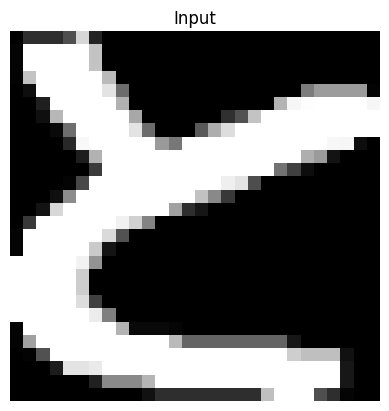

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


### Predicted Hiragana: と

In [16]:
if fill_borders:
    target = sections[2]
else:
    target = sections[1]
prediction = predict_hiragana(target, show_plot=True)
display(Markdown('### Predicted Hiragana: {}'.format(class2unicode[prediction])))

Finalmente, este proceso se ejecuta por cada hiragana ordenado por posicionamiento en la imágen. De esta manera, se obtiene el texto del cartel.

In [17]:
selected_row = []

for idx, limits in enumerate(section_limits):
        selected_row.append(idx)
        print(idx, limits)

selected_row = sorted(selected_row, key=lambda idx: section_limits[idx][1][0])

predictions = [class2unicode[x] for x in map(lambda x: predict_hiragana(sections[x]), selected_row)]

predicted_word = "".join(predictions)
display(Markdown('### Predicted Hiragana word: {}'.format(predicted_word)))

0 ((np.int32(20), np.int32(50)), (np.int32(49), np.int32(87)))
1 ((np.int32(18), np.int32(53)), (np.int32(194), np.int32(231)))
2 ((np.int32(15), np.int32(53)), (np.int32(343), np.int32(372)))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


### Predicted Hiragana word: つてと